In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
import numpy as np
import pandas as pd 
import os
from PIL import Image 
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt 

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

torch.manual_seed(45)
np.random.seed(45)

cuda:0


In [5]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
props = torch.cuda.get_device_properties(0)
print(props)

1
NVIDIA GeForce RTX 4060
_CudaDeviceProperties(name='NVIDIA GeForce RTX 4060', major=8, minor=9, total_memory=7796MB, multi_processor_count=24, uuid=089b23a4-ea2c-397c-2e09-e0be5e7421ac, pci_bus_id=1, pci_device_id=0, pci_domain_id=0, L2_cache_size=24MB)


In [6]:
# Custom Dataset class modeled after Pytorch dataset. Created to avoid 'class-per-folder' 
# organization that is required by standard pytorch datasets.

# BLAME: Zebulon Mcknight *** 

class DogBreedDataset(Dataset):
    # __init__ receives a pandas dataframe of form ('id')('breed'), a directory
    # containing images, a dict of the form ('breed')(int label), and an optional
    # transform pipeline. 
    def __init__(self, label_df, img_dir, labels, transform=None): 
        self.labels_df = label_df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.classes = labels

    # __len__ simply returns the number of samples in a dataset
    def __len__(self): 
        return len(self.labels_df)
    
    # __getitem__ takes in an index representing an entry in the dataset, it returns the img 
    # and proper class label associated with that index 
    def __getitem__(self, index): 
        row = self.labels_df.iloc[index]
        path = os.path.join(self.img_dir, row["id"]+ ".jpg")
        img = Image.open(path)
        img = img.convert("RGB")

        if self.transform: 
            img = self.transform(img)

        label = self.classes[row['breed']]

        return img, label

In [7]:
# Reading in labels for each image 
# BLAME: Minh Cao *** 
labels = pd.read_csv("data/labels.csv")
breeds = labels['breed'].unique() 

# Dict mapping 'breed' to index, model will operate on integers and we will convert back to breeds 
classes = {b: i for i, b in enumerate(breeds)}

In [8]:
# Data Transformers 

# BLAME: Zebulon Mcknight ***

train_transforms = transforms.Compose([
    transforms.Resize((224,224)), # pytorch expects 224x224 sized images

    # These transformations are standard for introducing more randomness into the training set. 
    # These transformations haven't been tested and perfected individually, but instead
    # come as standard recommended parts of the pipeline for reducing overfitting and promoting
    # generalization 
    transforms.RandomHorizontalFlip(), 
    transforms.RandomResizedCrop(224, scale = (0.8, 1.0)),
    transforms.RandomRotation(15), 
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3), 
    transforms.ToTensor(), 

    # Here we normalize RGB values to the mean and standard deviation of the ImageNet dataset, 
    # the set that our pretrained model was trained on. 
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # pytorch expects 224x224 sized images
    transforms.ToTensor(),

    # Here we normalize RGB values to the mean and standard deviation of the ImageNet dataset, 
    # the set that our pretrained model was trained on. 
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [9]:
# Load all data into a dataset 
# BLAME: Minh Cao *** 
dataset = DogBreedDataset(labels, "data/train", classes, train_transforms)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [10]:
test = DogBreedDataset(labels, "data/test", classes, val_transforms)
test_df = dataset.labels_df

In [11]:
num_classes = len(dataset.classes)

In [12]:
# Split data into training and validation sets stratified by class membership 
# BLAME: Viwesh Gupta
train_df, val_df = train_test_split(dataset.labels_df, 
                                    test_size=0.2, 
                                    stratify=dataset.labels_df['breed'])

train_df.to_csv("train_split.csv", index=False)
val_df.to_csv("val_split.csv", index=False)

In [13]:
# Load split data into independent training and validation datasets
# BLAME: Kyle Bomar ***
 
train_dataset = DogBreedDataset(
    label_df=train_df,
    img_dir ='data/train',
    labels = classes,
    transform=train_transforms
)

val_dataset = DogBreedDataset(
    label_df = val_df,
    img_dir ='data/train',
    labels = classes, 
    transform=val_transforms
)

test_dataset = DogBreedDataset(
    label_df = test_df, 
    img_dir ='data/test', 
    labels = classes, 
    transform=val_transforms
)

In [25]:
# Define our dataloaders for training and validation
# BLAME: Kyle Bomar ***

train_loader = DataLoader(
    # these variable primarily affect efficiency at fetching data
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=8, # when running on windows num_worker must equal zero, there is a well known pytorch bug forcing this 
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=8,
    pin_memory=False
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=64, 
    shuffle=False, 
    num_workers=8,
    pin_memory=False
)


In [15]:
# Test if the dataset itself is working
# BLAME: Viwesh Gupta ***
for i in range(3):
    try:
        x, y = train_dataset[i]
        print(f"Item {i}: Image shape = {x.shape}, Label = {y}")
    except Exception as e:
        print(f"Error at index {i}: {e}")


Item 0: Image shape = torch.Size([3, 224, 224]), Label = 68
Item 1: Image shape = torch.Size([3, 224, 224]), Label = 79
Item 2: Image shape = torch.Size([3, 224, 224]), Label = 14


In [26]:
# DEFINING MODEL SPECIFICATIONS

# BLAME: Zebulon Mcknight and Minh Cao***

# This line represents our model. For this implementation we are 
# using resnet18 with weights pretrained on ImageNetV1. This is an
# industry standard Convolutional Neural Network designed for image
# classification. 
cnn = models.resnet18(weights="IMAGENET1K_V1")

# Here we freeze all but the last layer of the cnn, this lets us
# start from a good place for image classification but lets us
# design our own final layer for predictions. 
for param in cnn.parameters(): 
    param.requires_grad = False

# Our final layer. This resembles a 2 layer MLP (multi layer perceptron)
# That maps the hundreds or thousands of features present in the CNN 
# to the 120 outputs that we need to map to class probabilities. This layer is 
# the only layer we are training in our training loop. 
cnn.fc = nn.Sequential(
    nn.Linear(cnn.fc.in_features, 256), 
    nn.ReLU(), 
    nn.Dropout(0.5), # Using dropout will hurt training performance, but decrease overfitting 
    nn.Linear(256, num_classes)
)

cnn=cnn.to(device)
print(cnn)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
criterion = nn.CrossEntropyLoss() # we'll be using CrossEntropy loss 
# This is our optimizer, ADAM is similar to an improved verison of stochastic 
# gradient descent designed specifically for deep learning
optimizer = optim.Adam(cnn.fc.parameters(), lr=1e-3, weight_decay=1e-4) 

In [31]:
# TRAINING LOOP 

# BLAME: Zebulon Mcknight ***

# Our training function takes in a reference to our model, our training and validation
# loaders, a loss function, an optimizer, and a number of epochs to train for 
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs): 
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs): 
        model.train()

        # We will track loss and accuracy for each epoch 
        running_loss = 0.0
        running_corrects = 0

        # each epoch is broken into batches of 64 images
        for inputs, labels in tqdm(train_loader): 
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs,1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += (preds == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss} | Accuracy: {epoch_acc}")

        train_losses.append(epoch_loss)

        # Validation loop
        # BLAME: Kyle Bomar ***
         
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        with torch.no_grad(): 
            for inputs, labels in val_loader: 
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += (preds == labels).sum().item()
        
        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects / len(val_loader.dataset)
        print(f"Validation Loss: {val_loss} | Accuracy: {val_acc}")

        val_losses.append(val_loss)

    return train_losses, val_losses 


In [24]:
def evaluate(model, test_loader): 
    model.eval()
    predictions = []

    with torch.no_grad(): # do not use gradients when testing 
        for inputs in test_loader: 
            inputs = inputs.to(device)
            outputs = model(inputs)

            # make a prediction, convert it to numpy, and track it for submission 
            _, prediction = torch.max(outputs, 1)
            prediction = prediction.numpy()

            for sample in prediction: 
                predictions.append(sample)
            

    return np.array(predictions)

In [29]:
torch.set_num_threads(os.cpu_count())
print(os.cpu_count())

28


In [32]:
train_loss, val_loss = train(cnn, train_loader, val_loader, criterion, optimizer, num_epochs=25)

100%|██████████| 128/128 [00:16<00:00,  7.69it/s]

Epoch 1/25 | Train Loss: 1.641523676220648 | Accuracy: 0.5256206432677021


Validation Loss: 1.1239581998811083 | Accuracy: 0.6801955990220049


100%|██████████| 128/128 [00:19<00:00,  6.67it/s]


Epoch 2/25 | Train Loss: 1.5739188722749495 | Accuracy: 0.5426195426195426
Validation Loss: 1.0869721880751892 | Accuracy: 0.684596577017115


100%|██████████| 128/128 [00:10<00:00, 12.05it/s]

Epoch 3/25 | Train Loss: 1.547524834373141 | Accuracy: 0.5488565488565489


Validation Loss: 1.0450866854861196 | Accuracy: 0.6875305623471882


100%|██████████| 128/128 [00:16<00:00,  8.00it/s]

Epoch 4/25 | Train Loss: 1.4814032116043578 | Accuracy: 0.564877094288859


Validation Loss: 1.0217158932266142 | Accuracy: 0.7085574572127139


100%|██████████| 128/128 [00:18<00:00,  6.74it/s]

Epoch 5/25 | Train Loss: 1.478397608576011 | Accuracy: 0.566956096367861


Validation Loss: 1.0557877658631807 | Accuracy: 0.6938875305623472


100%|██████████| 128/128 [00:10<00:00, 11.89it/s]

Epoch 6/25 | Train Loss: 1.4366627346263678 | Accuracy: 0.5783294606824019


Validation Loss: 1.0295949886655458 | Accuracy: 0.6958435207823961


100%|██████████| 128/128 [00:15<00:00,  8.20it/s]

Epoch 7/25 | Train Loss: 1.4237474172057303 | Accuracy: 0.5771065182829889


Validation Loss: 1.0033522230197283 | Accuracy: 0.697799511002445


100%|██████████| 128/128 [00:19<00:00,  6.65it/s]

Epoch 8/25 | Train Loss: 1.4048283434998834 | Accuracy: 0.5801638742815214


Validation Loss: 1.0156010345025284 | Accuracy: 0.684596577017115


100%|██████████| 128/128 [00:12<00:00, 10.47it/s]

Epoch 9/25 | Train Loss: 1.3832348821302258 | Accuracy: 0.591048061636297


Validation Loss: 0.9892303608448989 | Accuracy: 0.7075794621026895


100%|██████████| 128/128 [00:14<00:00,  9.06it/s]

Epoch 10/25 | Train Loss: 1.3740868621923907 | Accuracy: 0.6019322489910726


Validation Loss: 0.9971555260982373 | Accuracy: 0.7031784841075794


100%|██████████| 128/128 [00:19<00:00,  6.52it/s]

Epoch 11/25 | Train Loss: 1.356078603965402 | Accuracy: 0.6019322489910726


Validation Loss: 0.9908258358831802 | Accuracy: 0.6963325183374083


100%|██████████| 128/128 [00:15<00:00,  8.26it/s]

Epoch 12/25 | Train Loss: 1.3543602231080394 | Accuracy: 0.5989971872324813


Validation Loss: 1.030246596318877 | Accuracy: 0.6929095354523227


100%|██████████| 128/128 [00:12<00:00, 10.35it/s]

Epoch 13/25 | Train Loss: 1.3288939348916866 | Accuracy: 0.6070686070686071


Validation Loss: 1.007643034143378 | Accuracy: 0.6997555012224939


100%|██████████| 128/128 [00:17<00:00,  7.17it/s]

Epoch 14/25 | Train Loss: 1.3299072355749963 | Accuracy: 0.6051118992295463


Validation Loss: 0.9906992935901167 | Accuracy: 0.7051344743276283


100%|██████████| 128/128 [00:18<00:00,  6.76it/s]

Epoch 15/25 | Train Loss: 1.3198180930515628 | Accuracy: 0.5999755411520118


Validation Loss: 0.9886906184019262 | Accuracy: 0.6987775061124695


100%|██████████| 128/128 [00:12<00:00,  9.91it/s]

Epoch 16/25 | Train Loss: 1.3196185506671627 | Accuracy: 0.5986303045126574


Validation Loss: 0.9927060701444854 | Accuracy: 0.7007334963325184


100%|██████████| 128/128 [00:14<00:00,  8.97it/s]

Epoch 17/25 | Train Loss: 1.2883407313272337 | Accuracy: 0.6173413232236762


Validation Loss: 1.0073813296471947 | Accuracy: 0.6968215158924206


100%|██████████| 128/128 [00:19<00:00,  6.50it/s]

Epoch 18/25 | Train Loss: 1.2716753024175549 | Accuracy: 0.6163629693041458


Validation Loss: 0.9724878089643633 | Accuracy: 0.7124694376528118


100%|██████████| 128/128 [00:15<00:00,  8.03it/s]


Epoch 19/25 | Train Loss: 1.264313709215414 | Accuracy: 0.6181973829032652
Validation Loss: 0.9862009297081777 | Accuracy: 0.7002444987775062


100%|██████████| 128/128 [00:11<00:00, 11.57it/s]

Epoch 20/25 | Train Loss: 1.2739220401309763 | Accuracy: 0.610737434266846


Validation Loss: 1.0029431498429595 | Accuracy: 0.6997555012224939


100%|██████████| 128/128 [00:19<00:00,  6.59it/s]

Epoch 21/25 | Train Loss: 1.243377267534406 | Accuracy: 0.62052097346215


Validation Loss: 1.0191896055613288 | Accuracy: 0.6909535452322738


100%|██████████| 128/128 [00:17<00:00,  7.30it/s]

Epoch 22/25 | Train Loss: 1.2392650810447898 | Accuracy: 0.6221107985813868


Validation Loss: 0.9922619384192022 | Accuracy: 0.6963325183374083


100%|██████████| 128/128 [00:10<00:00, 12.50it/s]

Epoch 23/25 | Train Loss: 1.2573380590112049 | Accuracy: 0.6177082059435001


Validation Loss: 0.9953548666608946 | Accuracy: 0.7134474327628362


100%|██████████| 128/128 [00:18<00:00,  6.87it/s]

Epoch 24/25 | Train Loss: 1.2182920352016289 | Accuracy: 0.6321389262565733


Validation Loss: 0.9994350834114336 | Accuracy: 0.7080684596577017


100%|██████████| 128/128 [00:19<00:00,  6.62it/s]

Epoch 25/25 | Train Loss: 1.2319088356264853 | Accuracy: 0.6301822184175125


Validation Loss: 1.01551288590746 | Accuracy: 0.6992665036674817


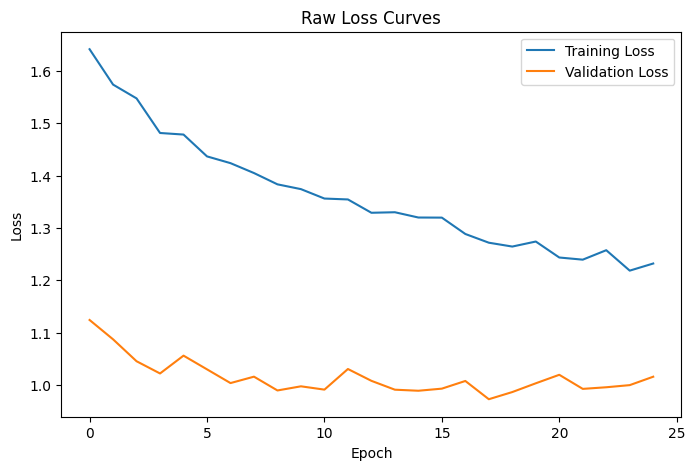

In [45]:
fig = plt.figure(figsize=(8,5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Raw Loss Curves')
plt.legend()
plt.show()
fig.savefig("results_figures/raw_loss.jpg")

In [39]:
train_loss = np.array(train_loss)
cum_train_loss = np.cumsum(train_loss)
avg_train_loss = cum_train_loss / np.arange(1, len(train_loss) + 1)

val_loss = np.array(val_loss)
cum_val_loss = np.cumsum(val_loss)
avg_val_loss = cum_val_loss / np.arange(1, len(val_loss) + 1)

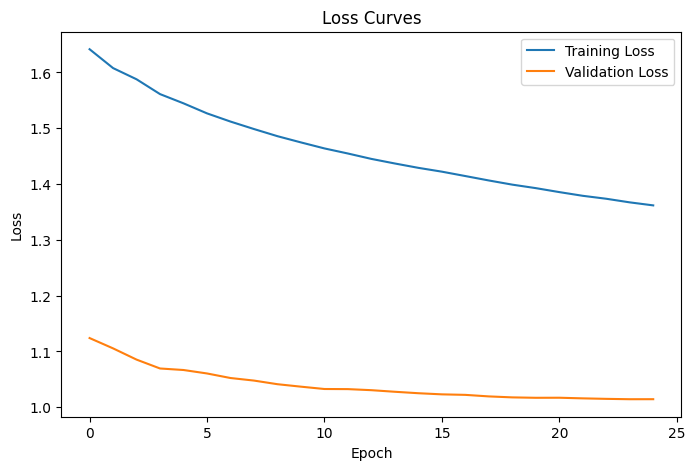

In [ ]:
fig = plt.figure(figsize=(8,5))
plt.plot(avg_train_loss, label='Training Loss')
plt.plot(avg_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Avg Loss Curves')
plt.legend()
plt.show()
fig.savefig("results_figures/avg_loss.jpg")

In [49]:
model_state = cnn.state_dict()

torch.save(model_state, "model_1.0")

In [ ]:
# load trained model from storage
state_dict = torch.load("model_1.0", map_location=device)
cnn.load_state_dict(state_dict)

<All keys matched successfully>

In [25]:
predictions = evaluate(cnn, test_loader)

FileNotFoundError: [Errno 2] No such file or directory: 'data/test\\000bec180eb18c7604dcecc8fe0dba07.jpg'